In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis
from statsmodels.stats.diagnostic import linear_reset, het_white


import warnings
warnings.filterwarnings('ignore')

**Предобработка**

In [65]:
data = pd.read_csv('data_after_processing.csv')
data.columns = [col.replace(' ', '_') for col in data.columns]

In [66]:
not_null = ['thickness', 'width', 'length', 'volume']
data = data[(data[not_null] > 0).all(axis=1)]

In [67]:
#data = data.drop(['title'], axis=1)
data = data.drop(['author_Другой', 'publisher_Другой', 'publication_year_Другой',
                  'cover_type_Мягкий_заламинированный_картон', 'cover_type_Твёрдый_переплёт', 'reading_age_12+', 'is_russian_author_0', 'is_russian_author_1'], axis=1)

In [68]:
data.columns

Index(['price', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage', 'weight',
       'author_Джейн_Остен', 'author_Джек_Лондон', 'author_Джордж_Оруэлл',
       'author_Лев_Толстой', 'author_Луиза_Мэй_Олкотт',
       'author_Михаил_Булгаков', 'author_Николай_Гоголь',
       'author_Федор_Достоевский', 'author_Эрих_Ремарк', 'publisher_АСТ',
       'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Манн,_Иванов_и_Фербер', 'publisher_Эксмо',
       'publication_year_2021', 'publication_year_2022',
       'publication_year_2023', 'publication_year_2024',
       'publication_year_2025', 'cover_type_Мягкий_переплёт', 'reading_age_0+',
       'reading_age_16+', 'reading_age_18+', 'reading_age_6+', 'thickness',
       'width', 'length', 'volume'],
      dtype='object')

In [69]:
X, y = data.drop(['price'], axis=1), data['price']
X = sm.add_constant(X)

**Отбор объясняющих переменных**

Было принято решение удалить всех авторов тк по ним очень мало наблюдений

In [70]:
X.drop(columns = ['author_Джейн_Остен', 'author_Джек_Лондон', 'author_Джордж_Оруэлл',
       'author_Лев_Толстой', 'author_Луиза_Мэй_Олкотт',
       'author_Михаил_Булгаков', 'author_Николай_Гоголь',
       'author_Федор_Достоевский', 'author_Эрих_Ремарк'], inplace=True)

Выкидываем по-очереди вес, толщину, объем, страницы, площадь, длину, ширину смотрим на R2 и на коэффициент при обложке

In [71]:
X['S'] = X['length'] * X['width']

In [72]:
from itertools import combinations
groups = ['weight', 'thickness', 'volume', 'width', 'length', 'S']

to_data_frame = []

for r in range (1, len(groups) + 1):
    for group in combinations(groups, r=r):
        group = list(group)
# for group in groups_to_test:
        X_full = X.copy()
        X_reduced = X.drop(columns=group)
        model_full = sm.OLS(y, X_full).fit()
        model_reduced = sm.OLS(y, X_reduced).fit()

        f_stat, p_val, df_diff = model_full.compare_f_test(model_reduced)
        # print(f"Группа: {group}, F = {f_stat}, p = {p_val}")
        r = model_reduced.rsquared_adj
        # b_cover = model_reduced.params['cover_type_Мягкий_переплёт']
        b_pages = model_reduced.params['pages_cnt']
        aic = model_reduced.aic

        if (b_pages > 0):
            dct = {'group': group,
                  'r': r,
                  'b_pages' : b_pages}

            to_data_frame.append(dct)

data_frame_info = pd.DataFrame(to_data_frame)
data_frame_info.sort_values(by=['r'], ascending=False)

,group,r,b_pages
0,[weight],0.742979,0.198612
3,"[weight, width]",0.728274,0.216185
14,"[weight, width, S]",0.728023,0.215811
5,"[weight, S]",0.728020,0.215338
4,"[weight, length]",0.722819,0.215002
13,"[weight, width, length]",0.721443,0.210861
23,"[weight, width, length, S]",0.720517,0.210317
15,"[weight, length, S]",0.720431,0.210419
1,"[weight, thickness]",0.711167,0.005746
7,"[weight, thickness, width]",0.696173,0.022580


In [73]:
X.drop(columns=['weight', 'volume', 'thickness', 'length', 'width', 'S'], inplace = True)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:36:06   Log-Likelihood:                -21905.
No. Observations:                3190   AIC:                         4.385e+04
Df Residuals:                    3170   BIC:                         4.397e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Тк часть публикационных годов незначима, давайте объединим - судя по ящику с усами 24 и 25 год стоит дороже

In [74]:
X['2024_or_2025'] = X['publication_year_2024'] + X['publication_year_2025']
X.drop(columns=['publication_year_2021', 'publication_year_2022',
       'publication_year_2023', 'publication_year_2024', 'publication_year_2025'], inplace=True)

In [75]:
groups_to_test = [['2024_or_2025']]
for group in groups_to_test:
    X_full = X.copy()
    X_reduced = X.drop(columns=group)
    model_full = sm.OLS(y, X_full).fit()
    model_reduced = sm.OLS(y, X_reduced).fit()

    f_stat, p_val, df_diff = model_full.compare_f_test(model_reduced)
    print(f"Группа: {group}, F = {f_stat}, p = {p_val}, коэффициент оказался значим")

Группа: ['2024_or_2025'], F = 9.262100071087392, p = 0.0023586145341476824, коэффициент оказался значим


In [76]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     235.6
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:36:13   Log-Likelihood:                -21907.
No. Observations:                3190   AIC:                         4.385e+04
Df Residuals:                    3174   BIC:                         4.394e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Некоторые рейтинги незначимы, давайте сделаем точно также, 0+ и 6+ стоят дороже. Оставшиеся объединим

In [77]:
X['6-'] = X['reading_age_0+'] + X['reading_age_6+']
X['16+'] = X['reading_age_16+'] + X['reading_age_18+']
X.drop(columns=['reading_age_0+', 'reading_age_6+', 'reading_age_16+', 'reading_age_18+'], inplace=True)

In [78]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     268.6
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:36:16   Log-Likelihood:                -21918.
No. Observations:                3190   AIC:                         4.386e+04
Df Residuals:                    3176   BIC:                         4.395e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Остался незначимым коэффициент при издательстве 'publisher_Манн,_Иванов_и_Фербер' По нему мало наблюдений, дропнем его, отнеся в категорию другое

In [79]:
X.drop(columns=['publisher_Манн,_Иванов_и_Фербер'], inplace=True)

In [80]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     291.0
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:36:20   Log-Likelihood:                -21918.
No. Observations:                3190   AIC:                         4.386e+04
Df Residuals:                    3177   BIC:                         4.394e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Теперь сделаем возвращение удаленных признаков, посмотрим, как они себя ведут

In [81]:
groups_to_test = [['publication_year_2021', 'publication_year_2022', 'publication_year_2023'],
                  ['publisher_Манн,_Иванов_и_Фербер']]
for group in groups_to_test:
    X_full = X.copy()
    X_reduced = X.copy()
    X_full[group] = data[group]
    model_full = sm.OLS(y, X_full).fit()
    model_reduced = sm.OLS(y, X_reduced).fit()

    f_stat, p_val, df_diff = model_full.compare_f_test(model_reduced)
    print(f"Группа: {group}, F = {f_stat}, p = {p_val}")
print('Все выкинутые группы по-прежнему незначимы')

Группа: ['publication_year_2021', 'publication_year_2022', 'publication_year_2023'], F = 1.0349866339120282, p = 0.3758769904309481
Группа: ['publisher_Манн,_Иванов_и_Фербер'], F = 0.011764867815294514, p = 0.9136329206973712
Все выкинутые группы по-прежнему незначимы


In [82]:
X.columns

Index(['const', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Мягкий_переплёт', '2024_or_2025', '6-',
       '16+'],
      dtype='object')

### Итоговый набор признаков:
['const', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Мягкий_переплёт', '2024_or_2025', '6-',
       '16+']

### Сохраняем данные

In [83]:
data_to_csv = pd.concat([y, X], axis=1)
data_to_csv

,price,const,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Мягкий_переплёт,2024_or_2025,6-,16+
0,312,1.0,4.1,925,512,30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,312,1.0,4.1,1341,320,30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,284,1.0,4.5,363,192,25000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,339,1.0,4.3,872,288,12000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,284,1.0,4.2,3004,320,30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1241,1.0,5.0,3,624,1500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3186,2207,1.0,3.7,53,448,1500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3187,1103,1.0,4.3,42,784,3000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3188,1011,1.0,3.8,29,704,2000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [84]:
data_to_csv.to_csv('data_after_feature_selection.csv', index=False)

## Сравнение функциональных форм на основе теста Бокса-Кокса и PE теста:

**Тест Бокса-Кокса с преобразование Зарембки (адекватный и рабочий)**

In [50]:
geo_mean = gmean(y)
y_help = y/geo_mean
ln_y_help = np.log(y_help)

lin_model = sm.OLS(y_help, X).fit()
rss1 = np.sum(lin_model.resid**2)

semi_log_model = sm.OLS(ln_y_help, X).fit()
rss2 = np.sum(semi_log_model.resid**2)

chi_stat = X.shape[0]/2 * np.abs(np.log(rss1/rss2))
print(f'{chi_stat} > 3.84 значит, между моделями есть существенное различие, выбираем на основе RSS')

1456.1341744874328 > 3.84 значит, между моделями есть существенное различие, выбираем на основе RSS


In [51]:
if rss2 < rss1:
  print('Полулогарифмическая модель предпочтительнее')
else:
  print('Линейная модель предпочтительнее')

Полулогарифмическая модель предпочтительнее


**Тест Бокса-Кокса (стремный и нерабочий)**

In [52]:
ln_y = np.log(y)

In [53]:
model = sm.OLS(y, X).fit()
rss1 = np.sum(model.resid**2)

semi_log_model = sm.OLS(ln_y, X).fit()
rss2 = np.sum(semi_log_model.resid**2)

y_boxcox, lambda_optimal = boxcox(y)

print(f"Оптимальное значение λ (метод Бокса-Кокса): {lambda_optimal}")

# Интерпретация
if np.isclose(lambda_optimal, 1, atol=0.1):
    print("Линейная модель (модель 1) предпочтительнее.")
elif np.isclose(lambda_optimal, 0, atol=0.1):
    print("Полулогарифмическая модель (модель 2) предпочтительнее.")
else:
    print("Ни одна из стандартных форм не идеальна, возможно, требуется промежуточная форма.")

Оптимальное значение λ (метод Бокса-Кокса): -0.8131464893394112
Ни одна из стандартных форм не идеальна, возможно, требуется промежуточная форма.


**PE тест**

In [54]:
model_log = sm.OLS(ln_y, X).fit()

yhat_lin = model.fittedvalues
ln_yhat_log = model_log.fittedvalues
yhat_log = np.exp(ln_yhat_log)

mask = yhat_lin >= 0

yhat_lin = yhat_lin[mask]
yhat_log = yhat_log[mask]
ln_y = ln_y[mask]
ln_yhat_log = ln_yhat_log[mask]
X_masked = X[mask]

# Шаг 2: Вспомогательные регрессии
aux_log_X = X_masked.copy()
aux_log_X['delta'] = yhat_lin - yhat_log
aux_log_model = sm.OLS(ln_y, aux_log_X).fit()

aux_lin_X = X_masked.copy()
aux_lin_X['delta'] = ln_yhat_log - np.log(yhat_lin)
aux_lin_model = sm.OLS(y[mask], aux_lin_X).fit()

print("Модель для полулогарифмической спецификации")
print()
print(aux_log_model.summary())

print("Модель для линейной спецификации")
print()
print(aux_lin_model.summary())


Модель для полулогарифмической спецификации

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     382.6
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:23:12   Log-Likelihood:                -824.59
No. Observations:                3181   AIC:                             1677.
Df Residuals:                    3167   BIC:                             1762.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

**Вывод:** все значимо, нужны другие функциональные формы

## Сравнение функциональных форм на основе нормированной R^2:

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     291.0
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:23:19   Log-Likelihood:                -21918.
No. Observations:                3190   AIC:                         4.386e+04
Df Residuals:                    3177   BIC:                         4.394e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        239.0553     58.455      4.090      0.000     124.442     353.668
avg_rating                    71.4526     12.078      5.916      0.000      47.770      95.135
cnt_reviews                    0.3925      0.041      9.640      0.000       0.313       0.472
pages_cnt                      0.5622      0.020     28.217      0.000       0.523       0.601
tirage                        -0.0243      0.002    -13.623      0.000      -0.028      -0.021
publisher_АСТ               -195.0463     22.296     -8.748      0.000    -238.761    -151.331
publisher_Азбука            -172.3658     23.565     -7.314      0.000    -218.570    -126.162
publisher_Иностранка          73.1580     29.507      2.479      0.013      15.303     131.013
publisher_Эксмо             -155.6886     22.102     -7.044      0.000    -199.023    -112.354
cover_type_Мягкий_переплёт  -270.4847      8.930    -30.291      0.000    -287.993    -252.976
2024_or_2025                  29.8545      9.663      3.090      0.002      10.908      48.800
6-                           395.6437     47.904      8.259      0.000     301.717     489.570
16+                           67.5216     11.281      5.985      0.000      45.402      89.641
==============================================================================
Omnibus:                     2435.121   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            98417.195
Skew:                           3.231   Prob(JB):                         0.00
Kurtosis:                      29.433   Cond. No.                     7.54e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
ln_X = np.log(data[num_features])
ln_X = pd.concat([ln_X, X.drop(columns=num_features)], axis=1)
ln_X = sm.add_constant(ln_X)

model_ln_X = sm.OLS(y, ln_X).fit()

In [ ]:
model_ln_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     251.1
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        07:49:09   Log-Likelihood:                -21756.
No. Observations:                3256   AIC:                         4.358e+04
Df Residuals:                    3222   BIC:                         4.379e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
avg_rating                         89.7436     49.336      1.819      0.069      -6.990     186.478
cnt_reviews                        13.7996      3.077      4.484      0.000       7.766      19.833
pages_cnt                        -321.2715     18.825    -17.066      0.000    -358.181    -284.362
tirage                            -84.9547      7.907    -10.744      0.000    -100.459     -69.451
weight                            717.8490     17.604     40.778      0.000     683.333     752.365
thickness                         -63.6595     20.762     -3.066      0.002    -104.367     -22.952
width                              94.4715     26.354      3.585      0.000      42.800     146.143
length                             43.6833     37.006      1.180      0.238     -28.873     116.240
volume                             74.4954     14.031      5.309      0.000      46.985     102.006
const                           -1738.4644    275.435     -6.312      0.000   -2278.510   -1198.418
author_Джейн Остен                -10.2398     24.044     -0.426      0.670     -57.382      36.903
author_Джек Лондон                -36.1602     23.519     -1.537      0.124     -82.275       9.954
author_Джордж Оруэлл               21.3754     24.843      0.860      0.390     -27.335      70.086
author_Лев Толстой                -61.2088     26.298     -2.327      0.020    -112.772      -9.646
author_Луиза Мэй Олкотт           -20.5420     27.651     -0.743      0.458     -74.757      33.673
author_Михаил Булгаков             87.2910     22.732      3.840      0.000      42.720     131.862
author_Николай Гоголь             -24.1705     28.019     -0.863      0.388     -79.108      30.767
author_Федор Достоевский          -42.9782     17.914     -2.399      0.016     -78.103      -7.853
author_Эрих Ремарк                 33.0632     24.960      1.325      0.185     -15.876      82.002
publisher_АСТ                     -57.7059     25.490     -2.264      0.024    -107.684      -7.728
publisher_Азбука                   -0.6769     26.406     -0.026      0.980     -52.452      51.098
publisher_Иностранка               79.2501     29.877      2.653      0.008      20.670     137.830
publisher_Манн, Иванов и Фербер   -81.4442     33.898     -2.403      0.016    -147.908     -14.980
publisher_Эксмо                   -70.0747     25.736     -2.723      0.007    -120.536     -19.614
publication_year_2021             -52.2297     38.371     -1.361      0.174    -127.463      23.003
publication_year_2022             -83.4072     32.037     -2.603      0.009    -146.222     -20.592
publication_year_2023             -66.2700     30.789     -2.152      0.031    -126.639      -5.901
publication_year_2024             -51.9486     30.227     -1.719      0.086    -111

**Вывод:** при сравнении ln_X - y с X - y нормированный R^2 лучше у X - y

In [ ]:
ln_X.shape[0], len(ln_y)

(3256, 3252)

In [ ]:
model_ln_X_ln_y = sm.OLS(ln_y, ln_X).fit()
model_ln_X_ln_y.summary()

ValueError: The indices for endog and exog are not aligned

In [ ]:
model_ln_y = sm.OLS(ln_y, X).fit()
model_ln_y.summary()

ValueError: The indices for endog and exog are not aligned

**Вывод:** незначительно лучше ln_y - X, чем ln_y - ln_X

## Еще одно подтверждение этому:

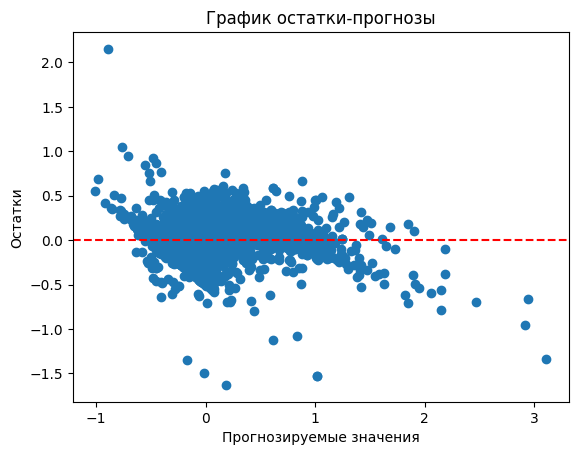

In [ ]:
# Визуальный анализ
residuals_ln_y = semi_log_model.resid
fitted_values_ln_y = semi_log_model.fittedvalues

plt.scatter(fitted_values_ln_y, residuals_ln_y)
plt.axhline(0, color='red', linestyle='--')  # Прямая "остатки = 0"
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('График остатки-прогнозы')
plt.show()

**Тест Рамсея**
<br>
Посмотрим на то, квадраты каких переменных стоит включать

In [ ]:
reset_result = linear_reset(model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=57.296244584653955, p-value=3.748703346023147e-14, df_denom=1>


**Вывод:** тест Рамсея показывает, что добавление степеней в модель помогает лучше описать данные

Проверим необходимость в квадратах тех признаков, которые сильнее всего влияют на себестоимость

In [ ]:
X_ramsey = X.copy()
X_ramsey["weight ** 2"] = X_ramsey["weight"]**2
model_for_ramsey = sm.OLS(y, X_ramsey).fit()

RSS_with = sum(model_for_ramsey.resid**2)
RSS_without = sum(model.resid**2)

k_reduced = X.shape[1]
k_full = X_ramsey.shape[1]

df1, df2 = k_full - k_reduced, len(y) - k_full

F_stat = ((RSS_without - RSS_with) / df1) / (RSS_with / df2)
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"F-статистика: {F_stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: Переменная weight^2 значима и улучшает модель.")
else:
    print("Не отвергаем H0: Переменная weight^2 незначима и может быть исключена.")

F-статистика: 0.9732069707708837
p-value: 0.32395579015186704
Не отвергаем H0: Переменная weight^2 незначима и может быть исключена.


In [ ]:
X_ramsey = X.copy()
X_ramsey["pages_cnt ** 2"] = X_ramsey["pages_cnt"]**2
model_for_ramsey = sm.OLS(y, X_ramsey).fit()

RSS_with = sum(model_for_ramsey.resid**2)
RSS_without = sum(model.resid**2)

k_reduced = X.shape[1]
k_full = X_ramsey.shape[1]

df1, df2 = k_full - k_reduced, len(y) - k_full

F_stat = ((RSS_without - RSS_with) / df1) / (RSS_with / df2)
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"F-статистика: {F_stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: Переменная pages_cnt^2 значима и улучшает модель.")
else:
    print("Не отвергаем H0: Переменная pages_cnt^2 незначима и может быть исключена.")

F-статистика: 48.41131925730164
p-value: 4.168554390560075e-12
Отвергаем H0: Переменная pages_cnt^2 значима и улучшает модель.


**Включение неважной переменной** (F-test)

**Тесты на гетероскедастичности**

In [ ]:
residuals = model.resid

In [ ]:
# Тест Уайта
white_test = het_white(residuals, X)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

In [ ]:
# Тест Уайта
white_test = het_white(residuals_ln_y, X)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

In [ ]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")


In [ ]:
# Тест Глейзера
abs_residuals = np.abs(residuals_ln_y)
glejser_model = sm.OLS(abs_residuals, X).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")


**Гипотеза о незначимости**

**Тест Чоу**